In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

In [3]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [4]:
METRICS = ['categorical_accuracy', Precision(), Recall()]

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNet
num_classes=2
# Load pre-trained models

mobilenet_base = MobileNet(weights='imagenet', include_top=False)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False)

# Define input shape
input_shape = (224, 224, 3)  # Adjust this based on your input image size

# Create model inputs
input_layer = Input(shape=input_shape)

# Get feature maps from both models
mobilenet_features = mobilenet_base(input_layer)
efficientnet_features = efficientnet_model(input_layer)

# Concatenate the feature maps
concatenated_features = Concatenate()([mobilenet_features, efficientnet_features])

# Global Average Pooling Layer
global_avg_pooling = GlobalAveragePooling2D()(concatenated_features)

# Add a Dense layer for classification
output_layer = Dense(num_classes, activation='softmax')(global_avg_pooling)  # Specify the number of output classes

# Create the fusion model
fusion_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
fusion_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=METRICS)

# Print a summary of the fusion model
fusion_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenet_1.00_224 (Functional  (None, None, None,   3228864    ['input_3[0][0]']                
 )                              1024)                                                             
                                                                                                  
 efficientnetb0 (Functional)    (None, None, None,   4049571     ['input_3[0][0]']                
                                1280)                                                         

C:\Users\rajru\anaconda3\envs\project\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

In [7]:
OUTPUT_PATH = 'dataset_subsets2'

In [8]:
IMG_DIMS = 100
TARGET_SIZE = (IMG_DIMS, IMG_DIMS)
COLOR_MODE = 'rgb'
CLASS_MODE = 'categorical'
BATCH_SIZE = 16
SEED = 123
random.seed(SEED)

In [9]:
#data preprocessing
TRAIN_PATH = os.path.join(OUTPUT_PATH, 'train')
train_datagen = ImageDataGenerator(
    
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True)
train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    seed=SEED)

Found 5382 images belonging to 2 classes.


In [10]:
# Take the path to the val folder and generate batches of data
VAL_PATH = os.path.join(OUTPUT_PATH, 'val')
val_datagen = ImageDataGenerator()
val_gen = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    seed=SEED)

Found 768 images belonging to 2 classes.


In [11]:
# Take the path to the train folder and generate batches of data
TEST_PATH = os.path.join(OUTPUT_PATH, 'test')
test_datagen = ImageDataGenerator()
test_gen = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 1541 images belonging to 2 classes.


In [12]:
# Define hyperparameters
EPOCHS = 5
ETA = 0.0001

In [13]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [14]:
METRICS = ['categorical_accuracy', Precision(), Recall()]

In [15]:
# Create a learning rate scheduler callback
def scheduler(epoch):
    if epoch > 19:
        return ETA * 0.1
    else:
        return ETA
callback = LearningRateScheduler(scheduler)

In [16]:
train_gen.labels


array([0, 0, 0, ..., 1, 1, 1])

In [17]:
# Estimate class weights for the unbalanced dataset
cls_wt = compute_class_weight(class_weight='balanced',
                              classes=np.unique(train_gen.labels),
                              y=train_gen.labels)
class_weight = {0: cls_wt[0], 1: cls_wt[1]}
print(class_weight)

{0: 1.0003717472118958, 1: 0.99962852897474}


In [18]:
# Train the model
history = fusion_model.fit(train_gen,
                    epochs=EPOCHS,
                    callbacks=callback,
                    validation_data=val_gen,
                    class_weight=class_weight)

Epoch 1/5
337/337 [==============================] - 271s 776ms/step - loss: 0.0142 - categorical_accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - val_loss: 3.4381e-05 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 2/5
337/337 [==============================] - 626s 2s/step - loss: 5.2987e-04 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 7.6585e-06 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 3/5
337/337 [==============================] - 264s 782ms/step - loss: 5.0339e-04 - categorical_accuracy: 0.9998 - precision: 0.9998 - recall: 0.9998 - val_loss: 6.7444e-06 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 4/5
337/337 [==============================] - 274s 812ms/step - loss: 0.0011 - categorical_accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - val_loss: 9.8065e-05 - va

In [19]:
def plot_metric_history(metric, val_metric, y_label, title):
    """
    Plots a training history metric.

    :param metric: the metric key
    :param val_metric: the validation metric key
    :param y_label: the y-axis label
    :param title: the title
    :return: None
    """
    plt.figure(facecolor='white', figsize=(8, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.ylabel(y_label)
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend(['training', 'validation'])
    plt.savefig(y_label + '.png', dpi=200)
    plt.show()

In [20]:
fusion_model.save_weights("final_fusion2.h5")

In [21]:
filepath="final_fusion2.hdf5"
fusion_model.save(filepath)

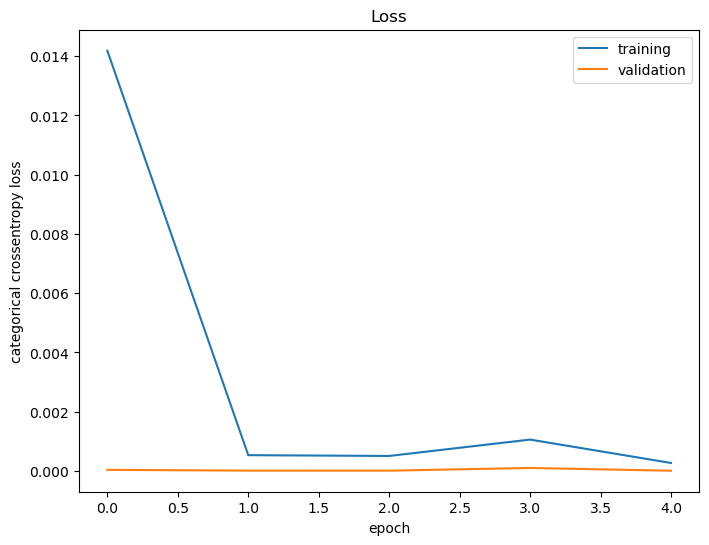

In [22]:
# Visualize loss history
plot_metric_history(metric='loss',
                    val_metric='val_loss',
                    y_label='categorical crossentropy loss',
                    title='Loss')

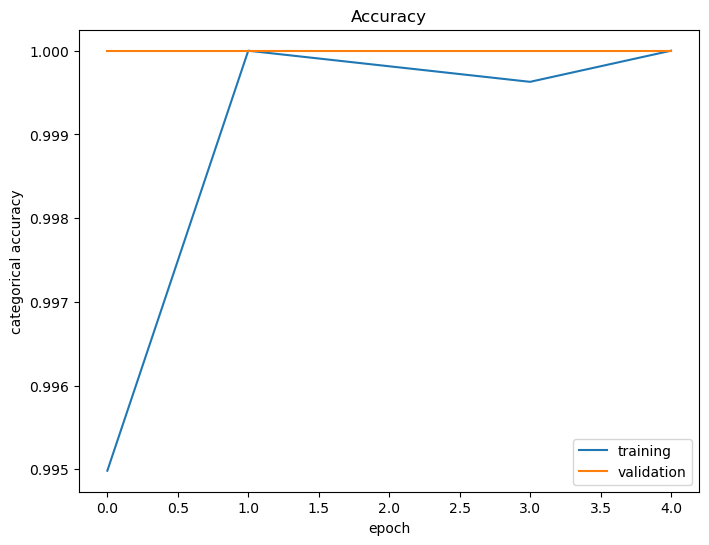

In [23]:
# Visualize accuracy history
plot_metric_history(metric='categorical_accuracy',
                    val_metric='val_categorical_accuracy',
                    y_label='categorical accuracy',
                    title='Accuracy')

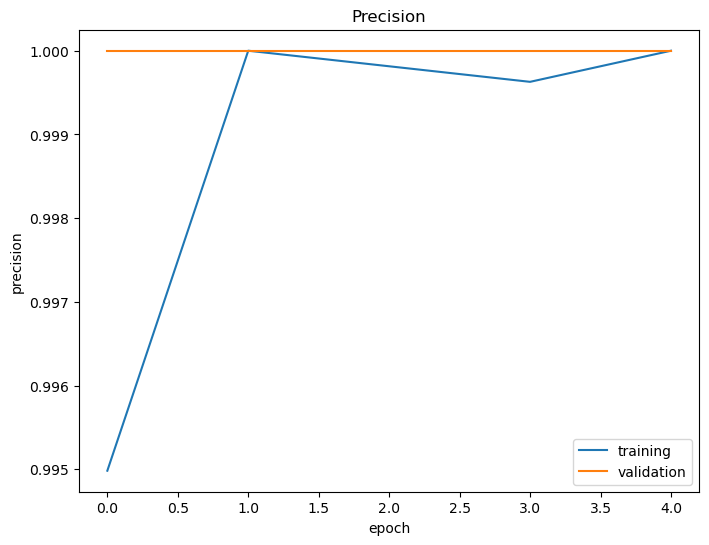

In [24]:
# Visualize precision history
plot_metric_history(metric='precision',
                    val_metric='val_precision',
                    y_label='precision',
                    title='Precision')

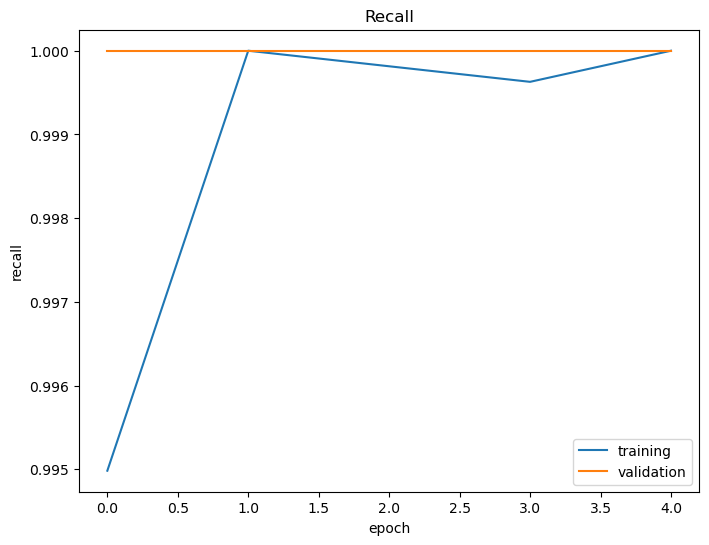

In [25]:
# Visualize recall history
plot_metric_history(metric='recall',
                    val_metric='val_recall',
                    y_label='recall',
                    title='Recall')

In [26]:
from tensorflow.keras.models import load_model
classifier = load_model('final_fusion2.hdf5')

In [27]:
def predict(image_path):
    from skimage import io
    from keras.preprocessing import image
    #path='imbalanced/Scratch/Scratch_400.jpg'
    import tensorflow as tf

    img = tf.keras.utils.load_img(image_path, grayscale=False, target_size=(224, 224))
    show_img=tf.keras.utils.load_img(image_path, grayscale=False, target_size=(224, 224))
    apple_class = ['Golden','Red']
    #disease_class = [0, 1, 2, 3]
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    #x = np.array(x, 'float32')
    #x /= 255

    custom = fusion_model.predict(x)
    print(custom)
    print(custom[0])



    #x = x.reshape([64, 64]);

    #plt.gray()
    plt.imshow(show_img)
    plt.show()

    a=custom[0]
    ind=np.argmax(a)

    print('Prediction:',apple_class[ind])


1/1 [==============================] - 2s 2s/step
[[9.9922132e-01 7.7864743e-04]]
[9.9922132e-01 7.7864743e-04]


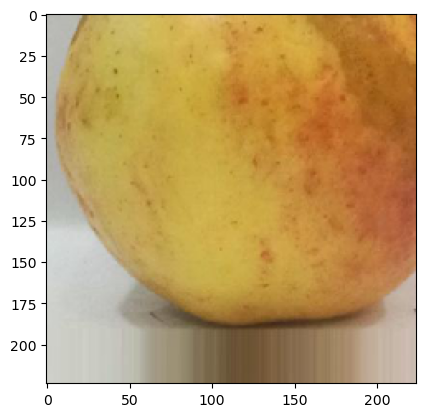

Prediction: Golden


In [28]:
predict('C:/Users/rajru/Desktop/code/augmented_images/golden/aug_0_57.jpeg')

1/1 [==============================] - 0s 55ms/step
[[9.99879956e-01 1.20082426e-04]]
[9.99879956e-01 1.20082426e-04]


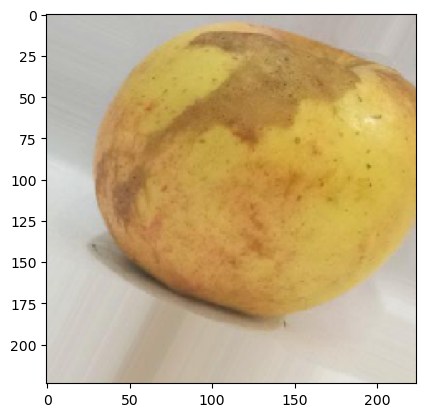

Prediction: Golden


In [29]:
predict('C:/Users/rajru/Desktop/code/augmented_images/golden/aug_0_295.jpeg')

1/1 [==============================] - 0s 52ms/step
[[5.094679e-05 9.999491e-01]]
[5.094679e-05 9.999491e-01]


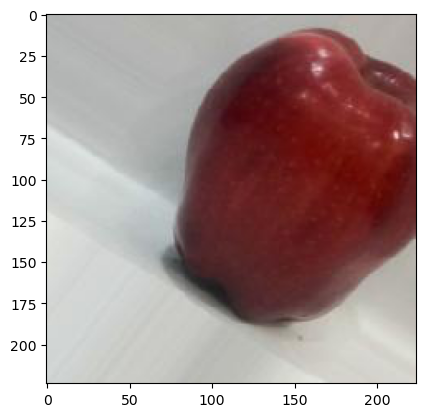

Prediction: Red


In [30]:
predict('C:/Users/rajru/Desktop/code/augmented_images/red/aug_0_802.jpeg')

In [ ]:
predict('C:/Users/rajru/Desktop/code/augmented_images/red/aug_0_639.jpeg')